In [1]:
#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [2]:
#read the dataset
listings_df = pd.read_csv('../input/seattle/listings.csv')
#read the dataset
calendar_df = pd.read_csv('../input/seattle/calendar.csv')

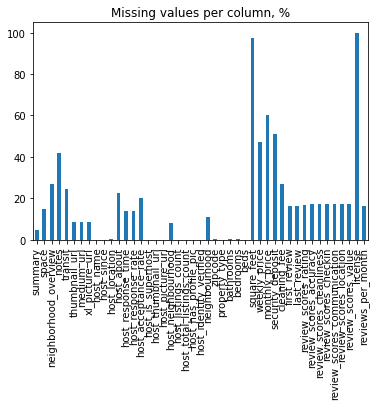

In [3]:
#find percentage of missing values for each column
listings_missing_df = listings_df.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#plot the results
listings_columns_with_nan.plot.bar(title='Missing values per column, %')

In [4]:
#merge datasets on listing_id
listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
df = pd.merge(calendar_df, listings_df, on = 'listing_id')

In [5]:
#drop the irrelevant columns
columns_to_drop = [ 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30','host_verifications','amenities','host_since',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped','first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
df = df.drop(columns = columns_to_drop)

In [6]:
#convert date from the calendar into month and drop the date colum
df['month'] = df.apply(lambda row: int(row['date'].split('-')[1]),axis=1)
df['year'] = df.apply(lambda row: int(row['date'].split('-')[0]),axis=1)
df = df.drop(columns = ['date'])

In [7]:
#remove rows where price_x == nan, because price will be used as response column
df = df.dropna(subset=['price_x'])
#convert price to number and drop the price_x column
df['price'] = df['price_x'].astype(str)
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
df = df.drop(columns = ['price_x'])

In [8]:
df["available"] = df["available"].map(lambda x: 1 if x=="t" else 0)

In [9]:
df["cleaning_fee"]=df.cleaning_fee.str.replace('$','').str.replace(',','').astype(float)

In [11]:
#convert host_response_rate into number and fill in missing values, drop the original column
df['host_response_rate_num'] = df['host_response_rate'].astype(str)
df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)

In [12]:
df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
#fill missing values with mean value for host_listings_count
df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)

In [13]:
#split host_verifications into dummy columns and drop the original column
#split_list_into_columns(df, 'host_verifications')
df = df.drop(columns = [])

In [15]:
#fill in missing values for bathrooms, bedrooms and beds with mode
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    

In [16]:
#turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
df['extra_people_fee'] = df.apply(lambda row: 1 if row['extra_people'] == '$0.00' else 0, axis=1)
df = df.drop(columns = ['extra_people'])

In [17]:
#fill missing values for review scores columns
review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']

In [18]:
#turn categorical columns into dummies
cat_columns = list(df.select_dtypes(include=['object']).columns)
    
for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)
#drop listing_id and year columns
df = df.drop(columns = ['listing_id', 'year'])

In [23]:
data_without_missing_values = df.dropna(axis=1)

In [24]:
#Diving the datasets into train and test datasets(70:30) for modelling

X = data_without_missing_values.drop(columns = 'price')
y = data_without_missing_values[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [25]:
#training RF regressor model
model_forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
model_forest.fit(X_train, y_train.squeeze())


y_train_preds = model_forest.predict(X_train)
y_test_preds = model_forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 208.728, test: 232.096
Random Forest R^2 train: 0.981, test: 0.979


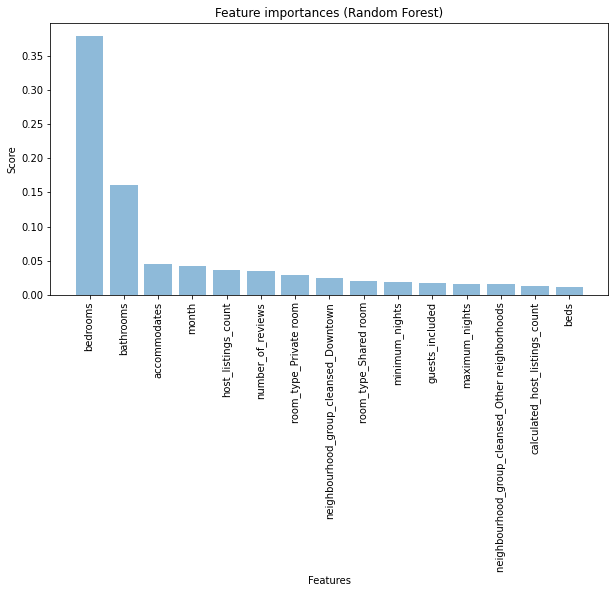

In [26]:
#get feature importances from the model
col_heads = ["name", "score"]
values = sorted(zip(X_train.columns, model_forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = col_heads)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

#plotting top 15 features as per feature importance
features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

In [27]:
#train XGBoost model
model_xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
model_xgb.fit(X_train,y_train)

#calculate and print scores for the model for top 15 features
y_train_preds = model_xgb.predict(X_train)
y_test_preds = model_xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

MSE train: 1083.651, test: 1088.854
R^2 train: 0.902, test: 0.900


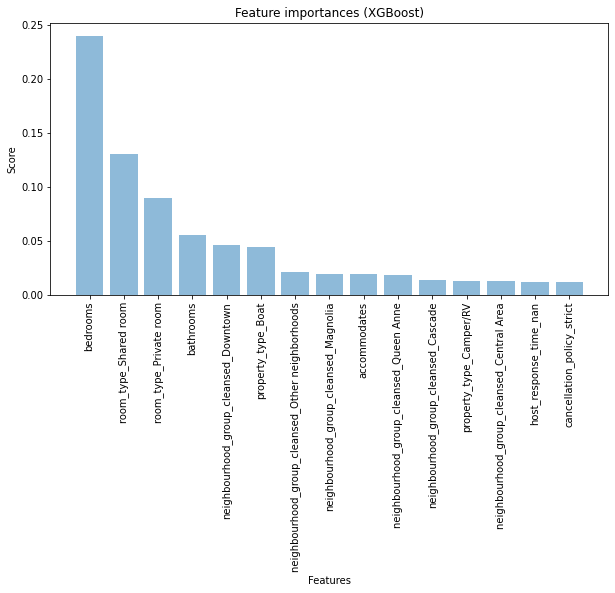

In [28]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plotting top 15 features as per feature importance
features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15]
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('feature importances XGB.png')
 
plt.show()